# Central London Data Science Project Nights
### Citigrapher 2: Navigating the London tube network

The focus of this meetup is in introducing graph structured data, and some manipulation by looking at a simple network optimisation problem.

## Overview

1. Data from Citygrapher 1 
2. Minimum Spanning Trees and Steiner Trees
3. Storage & Extension

Citigrapher is a tool that will help choose an optimum destination for a group of
users based on what activity they want to do, and where they all live and work. 
The optimum destination is thus one that has a good option of activites, such as
restaurants, pubs, music venues, museums etc, and ensure that the travel time for
everyone is equally spread, so that no one feels left out. 

In this chapter, these 3 parts will pick up from the last session where we used
Google maps APIs to find the nearest 3 tubes to a list of user requested postcodes. 
These postcodes represented where our users were starting and ending their day, 
and tus the travel time to these tubes was stored so we know to include this when 
working out the travel time for each user when we have decided on a potential optimum 
tube stop. 

We will then use these tubes to create a sub section of the London tube network 
that connects all our users, and thus must contain the optimum tube. This sub-network
can then be searched (in the next Citigrapher section) to find out each user's travel
time for each tube stop in this network to create a ranked list of tube stops, which
can then be used to query for a venue.

## 1. Data from Citygrapher 1

In this meetup we will be using the R package *igraph* to find the section of the
London tube network that connects all our users. To begin with we will load the 
required package and then read in our saved data from last time. 

---
N.B. WARNING FOR INSTALLING PACKAGES - I wrote this tutorial on windows, with Python 3.5 installed (should probs update that), and had to first install the windows binaries for python-igraph and pycairo as they have compiled C code. So to do this on a windows simply open cmd to the location that is where you have citigrapher/inst/extdata and then install them with pip install "inst/extdata/pycairo-1.13.2-cp35-cp35m-win_amd64.whl" and similar for igraph. I'm still very new to python so ask Zack or someone else for equivalents on mac or linux. 

THE FOLLOWING TWO STEPS ARE NEEDED TO PLOT THINGS USING CAIRO 
THEN you must go into where igraph has been installed and replace teh "igraph/drawing/_init_.py" with the one in inst/extdata. THEN you must go into where cairo isntalled and copy the .dll files within the inst/extdata folder.

---

The first thing we need to do is load the data from last time. This data has been 
saved within the inst/extdata folder as *"tubes.rds"*. For those who have not seen 
a *".rds"* file type before, it is simply a saved R object and can be read in as
follows:

In [1]:
## first let's load the necessary modules
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import igraph
import cairo
import pickle

## Read in the saved tube data
with open('inst/extdata/tubes.pkl', 'rb') as input:
    tubes = pickle.load(input)

The tubes object is a dict of dict with a length of 3, which contains information 
relating to our 3 users. Each internal dict shows the start and end location for
user as both their postcode, which they provided, and their latitidue and longitude,
which we looked up last time. It also then shows the closest 3 tubes to these locations
and the  walking travel time in seconds. Let's have a look at this data again to
refamiliarise ourselves. 

In [2]:
## View the saved tube data
tubes

{0: {'EndTubes': array(['tooting broadway', 'tooting bec', 'balham'], 
        dtype='<U27'),
  'EndTubesDistanceTimes': [2468, 2833, 3138],
  'Location': {'End': 'SW16 5YR',
   'EndLat': 51.41266599999999,
   'EndLong': -0.1455749,
   'Start': 'W12 0RQ',
   'StartLat': 51.5130878,
   'StartLong': -0.2378431},
  'StartTubes': array(['east acton', "shepherd's bush (h)", 'white city'], 
        dtype='<U27'),
  'StartTubesDistanceTimes': [2468, 2833, 3138]},
 1: {'EndTubes': array(['shadwell', 'wapping', 'stepney green'], 
        dtype='<U27'),
  'EndTubesDistanceTimes': [451, 896, 1064],
  'Location': {'End': 'E1 0AA',
   'EndLat': 51.5124971,
   'EndLong': -0.0520979,
   'Start': 'NW1 7DB',
   'StartLat': 51.5399046,
   'StartLong': -0.1468965},
  'StartTubes': array(['camden town', 'chalk farm', 'mornington crescent'], 
        dtype='<U27'),
  'StartTubesDistanceTimes': [451, 896, 1064]},
 2: {'EndTubes': array(['elephant & castle', 'kennington', 'borough'], 
        dtype='<U27'),


## 2. Minimum Spanning Trees and Steiner Trees

In this section we will be using the module *igraph* to find the section of the
London tube network that connects all our users. First we will read in the london tube network.

In [3]:
## Now let's read in the tube map and call it object g for graph
g = igraph.Graph.Read_GraphML(f="inst/extdata/tubemap.GraphML")

print(g)

IGRAPH DN-- 306 1546 --
+ attr: id (v), latitude (v), longitude (v), name (v), name.clean (v),
  name.display (v), zone (v), dist (e), line.colour (e), line.name (e),
  line.stripe (e)
+ edges (vertex names):
               baker street -> bond street, bond street, edgware road (c),
edgware road (c), finchley road, st. john's wood, st. john's wood, marylebone,
marylebone, regent's park, regent's park, great portland street, great
portland street, great portland street, great portland street, great portland
street, great portland street
              charing cross -> embankment, embankment, embankment, embankment,
embankment, embankment, embankment, embankment, leicester square, leicester
square, picadilly circus, picadilly circus
           edgware road (b) -> paddington, marylebone
          elephant & castle -> lambeth north, lambeth north, borough, borough,
kennington
                 embankment -> charing cross, charing cross, charing cross,
charing cross, charing cross, charing cr

The tube map is an igraph class object. An igraph object contains information, known
as attriutes, relating to the *vertices* (tube stops) and the *edges* (tube lines) within
the tube map, and which edges connect which vertices. So we can see for this graph
object we now the *latitude*, *longitude*, *name* and *zone* of the tube stops, and then 
also the distance, line *name*, *colour* and *stripe colour* of the tube lines. We also
have an attribute called *weight* that is the same as dist. 

The *igraph* package allows us to plot the tube map so we can see what we're looking at.
For those who have not seen the use of "::" before, this simply shows that the fucntion
after the "::" is within the namespace of the package listed before the "::". I tend
to include these as it makes it clearer where the function is coming from. You can, however,
use it without if the package is loaded, which it is due to *require(igraph)* and thus
*plot(g)* would also work with the correct plotting function being used based on the class
of the object g. 

In [17]:
## First plot the tube map as it is
igraph.plot(g,bbox = (400, 400), margin = 20)

## Now let's plot the tube map specifying some plotting variables

KeyboardInterrupt: 

We can see in the first plot that it's not very clear. This is because the plot function
simply plots the connects with an equal length and then optimises the layout. The
second plotting function fixes the vertices in terms of the longitude and latitude,
before colouring the edges by the tube line, and then scales it so it all fits within
the plotting window. (Otherwise it would try to fit everything in a [-1,1] square,
whereas our latitude in London is ~50)

Now we will want to create a Steiner Tree. There are many types of steiner tree, 
but paraphrasing it is how a group of vertices within the graph interconnect in 
some optimal way. For example, given our list of tubes a steiner tree would be the 
set of tube lnes that connect all these tubes in the shortest distance. For the purposes
of today, however, we will be creating a list of connections between the tube stops listed 
within the tubes object using our tube map graph, but we will not be optimising their 
connection. This is partly because this a difficult combinatorial optimisation problem
and because ultimately we are trying to eventually find a few tube stops that connect all
our tubes, which is a slightly different problem.

To do this we will follow the first 3 of 5 steps of Kou's algorithm to creating a Steiner
Tree, the last 2 of which involve the optimisation and thus we ignore. If anyone is
interested the paper where this was introduced can be found [here] (https://www.researchgate.net/publication/227056882_A_Fast_Algorithm_for_Steiner_Trees), which
combined with the wikipedia page for Steiner trees gives plenty of overview. 

To begin with we will want to create a new graph that connects all our tube stops.

In [9]:
## first lets extract a list of all the tubes from the all_tubes dict
all_tubes = list()

for i in range(0,len(tubes)-1):
    
    all_tubes.extend(tubes[i]['StartTubes'])
    all_tubes.extend(tubes[i]['EndTubes'])

all_tubes
len(all_tubes)

12

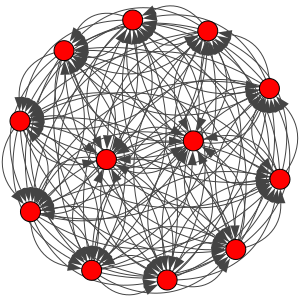

In [19]:
## Next let's create a new graph that connects all our tubes and call it gi
gi = igraph.Graph.Full(len(all_tubes),directed = True)

## What does this look like
igraph.plot(gi,bbox = (300, 300), margin = 20)

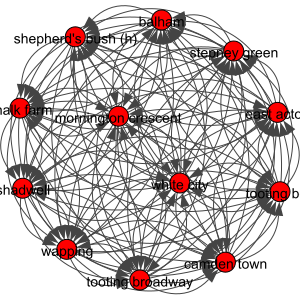

In [20]:
## Let's now label the graph vertices with our tube names
gi.vs["name"] = all_tubes
gi.vs["label"] = g.vs["name"]

## And plot again
igraph.plot(gi,bbox = (300, 300), margin = 20)

What we have done above is create a graph that connects all the certices to 
each other. The graph we have created is directed, which means that going from
A to B is different from B to A, which is important as some tube travel times 
are (apparantly accroding to tfl) different each way. We have then labelled them
with the tube names, using *V(gi)$name*, which selects all the vertices with 
*V(gi)* ad then assigns a new attribute called *name*. The function *E()* does the
same for edges. These function are used a lots below and as such I have not used the "::".

Next we will create from that a minimum spanning tree (mst), which is the shortest
way of connecting all the vertices given the edges, and then collect the edges within
this.

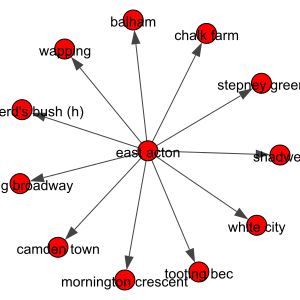

In [24]:
## Create the mst
mst = igraph.Graph.spanning_tree(gi)

## What does this look like
igraph.plot(mst,bbox = (300, 300), margin = 20)

In [50]:
##  Let's now grapb teh list of edges within the mst
edge_list = igraph.Graph.get_edgelist(mst)

## quickly view what the edge_list object looks like now
print(edge_list)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11)]


The next step is the longest, and seeks to replace each of the edges in the mst
with the shortest path that connects these edges within the actual tube map. To 
do this we will loop over the edge list, search if there is a connection between
them (which there always will be as the tube map is fully connected), and then
look up the shortest path between them. Then we will replace the edge within the
mst with this shortest path to produce the sub network we are looking for.

In [39]:
## First create a copy of the mst
gs = mst

## Loop through the edge list
for n in range(0,len(edge_list)-1):
  
  ## What is the from (i) and to (j) from the nth row in the edge list
    i=edge_list[n][0]
    j=edge_list[n][1]
    i_name = mst.vs['name'][edge_list[n][0]]
    j_name = mst.vs['name'][edge_list[n][1]]
   
    ## If edge is present then remove existing edge from the minimum spanning
    ## tree copy:
    gs = gs.delete_edges([i,j])
    
    ## Next extract the route, known as a subgraph, from g that corresponds to
    ## the shortest path  
    shortest_path = g.es[g.shortest_paths(source=g.vs['name'].index(i_name),target=g.vs['name'].index(j_name))]
    
    ### THIS IS WHERE I HAVE RUN OUT OF TIME UP TO BUT HOPEFULLY THE ANNOTATIONS GIVE A STARTING POINT
    
    ## make a subgraph from the shortest path which will look something like this
    
    #g_sub = g.shortest_paths()
    
    ## Now join this subgraoh with our mst copy, thereby replacing the oringinal
    ## connection:
    
    #gs = igraph.union(gs, g_sub, byname = T)
    
    
    ## The following is for tidying up. In short, when we union two graphs we
    ## also copy the attributes across. If they have the same name then they are
    ## turned into attribute_1 and attribute_2. Every time, however, that we do
    ## this we eventually lose information about the attributes as they get
    ## overwritten. The following simply takes attribute_1 and attribute_2 and
    ## combines them to create teh required attribute and asssigns it to gs.
    
    ## concatenate duplicate attributes as they appear
    
    ## FOR THE MOMENT HAVE A LOOK AT THE R TUTORIAL FOR THIS


SyntaxError: invalid syntax (<ipython-input-39-2cf2b8d3153c>, line 13)

The above will now have produced a subgraph that connects all our tubes in a way
that does not include too many unnecessary other tube stops. Let's have a look at that.

In [ ]:
# plot subgraph

Now we can have a look to see how this relates to our original tube stop locations,
to give some piece of mind that it actually looks sensible.


In this plot, only tubes with labels are ones within our subgraph and we can see
that they capture well where our users are based. 

## 3. Storage and Extension

The last section is shorter and more open ended again for everyone to start thinking
about how might be best to store data as citigrapher grows, and also how best 
to improve on this section. 

Firstly, let's save the object gs that we have created, so we can use it next time.

In [ ]:
# save the objet for next time

We also might want to start thinking about improvements to the above. Firstly, 
we can see that there are unnecessary tubes to the west of A_Start. This extra
loop of tubes seems unlikely to be helpful, and results from having East Acton
as our centre within the mst. Thus we could iterate around the mst process by adding
the edge weights to the fully connected graph. 

Going forward we will want to then start thinking about how we might search within
this subgraph for the distance for each user to a tube stop. We could do this with
brute force, iteratively going through each tube. This will take a long time so 
perhaps pruning our subgraph to not include this western loop might make sense.
This represents some of the last steps within Kou's algorithm. There are lots
of other things that need to be extended at the moment (tube line changes, number
of changes people want to make, night tube considerations etc), but hopefully we can 
start to see it taking shape. 

---

## Summary

Hopefully the above tutorial has shown a framework in R of how we can start probing
the london tube map as a graph object using the *igraph* package. As always if anyone
has any other ideas, or ways of approaching this problem then let me know either
as an issue in the github repo, or drop me a message. I hope this has been useful 
and interesting, and next time we will (probably) move to part 4 (as part 3 will
be more graph theory so let's keep it varied!) and start looking for how to search
google for posible activities and ways of ranking them given we have a set of tube stops
we are happy with as a result of part 3. 
